# **Path**

In [1]:
dataset_path = r'../input/a-large-scale-fish-dataset/NA_Fish_Dataset'

# **Libraries**

In [2]:
# Pytorch Libraries
import torch 
import torchvision 
import torch.nn as nn
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim 
import optuna
import albumentations as A
from albumentations.pytorch import ToTensorV2

# some other useful Libraries
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import copy
from PIL import Image
from pandas.core.common import flatten  


# **DATA AUGMENTATION**

In [3]:
train_transforms = A.Compose(
    [   
        A.Resize(224, 224),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=.2),        
            A.Blur(blur_limit=3, p=.2),              
        ], p=0.2),                                  

        A.SmallestMaxSize(max_size=350),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_transforms = A.Compose(
    [
        A.Resize(224, 224),
        A.SmallestMaxSize(max_size=220),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

test_transforms = A.Compose(
    [   
        A.Resize(224, 224),
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

# **Making Dataset** 

In [4]:
Image_paths = []
classes = []

for image in glob.glob(dataset_path+'/*'):
    print(image.split('/')[-1])
    classes.append(image.split('/')[-1])
    Image_paths.append(glob.glob(image+'/*'))
    
Image_paths = list(flatten(Image_paths))  # converting Higher dim to lower dim
random.shuffle(Image_paths)

print('\n',Image_paths[4])
print(classes[4])
print('\nsize of Images are:', len(Image_paths))

Black Sea Sprat
Sea Bass
Red Mullet
Trout
Striped Red Mullet
Shrimp
Red Sea Bream
Horse Mackerel
Gilt Head Bream

 ../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Shrimp/00020.png
Striped Red Mullet

size of Images are: 430


# **Spliting DataSet**

In [5]:
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths, test_image_paths = Image_paths[:int(0.6*len(Image_paths))],Image_paths[int(0.6*len(Image_paths)):int(0.8*len(Image_paths))],Image_paths[int(0.8*len(Image_paths)):]
print("The size of whole datasets is :", len(Image_paths))
print(f'The size of Train images are {len(train_image_paths)}')
print(f'The size of validation images are {len(valid_image_paths)}')
print(f'The size of test images are {len(test_image_paths)}')

The size of whole datasets is : 430
The size of Train images are 258
The size of validation images are 86
The size of test images are 86


# **Label Encoding**

In [6]:
## let's generate label of each class
idx_to_cls = {i:j for i, j in enumerate(classes)}
# print(idx_to_cls[1])
cls_to_idx = {value:key for key, value in idx_to_cls.items()}
cls_to_idx

{'Black Sea Sprat': 0,
 'Sea Bass': 1,
 'Red Mullet': 2,
 'Trout': 3,
 'Striped Red Mullet': 4,
 'Shrimp': 5,
 'Red Sea Bream': 6,
 'Horse Mackerel': 7,
 'Gilt Head Bream': 8}

# **Preparing Datasets**

In [7]:
class FishDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = cls_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label


train_dataset = FishDataset(train_image_paths,train_transforms)
valid_dataset = FishDataset(valid_image_paths,val_transforms) 
test_dataset = FishDataset(test_image_paths,test_transforms)

In [8]:
print(next(iter(train_dataset[9])))

print(len(test_dataset))

tensor([[[-1.4329, -1.4500, -1.4500,  ..., -1.7069, -1.7583, -1.7754],
         [-1.4329, -1.4329, -1.4500,  ..., -1.6727, -1.7412, -1.7412],
         [-1.4329, -1.4329, -1.4329,  ..., -1.6555, -1.6898, -1.7069],
         ...,
         [-1.3987, -1.3815, -1.3815,  ..., -0.8678, -0.9020, -0.9192],
         [-1.3987, -1.3815, -1.3644,  ..., -0.8678, -0.8849, -0.9192],
         [-1.3815, -1.3815, -1.3644,  ..., -0.8678, -0.8849, -0.9020]],

        [[-0.6001, -0.6176, -0.6176,  ..., -1.2479, -1.2829, -1.2829],
         [-0.6001, -0.6001, -0.6176,  ..., -1.2479, -1.2829, -1.2829],
         [-0.5826, -0.6001, -0.6176,  ..., -1.2479, -1.2829, -1.2829],
         ...,
         [-1.0553, -1.0553, -1.0378,  ..., -0.7227, -0.7227, -0.7227],
         [-1.0728, -1.0553, -1.0378,  ..., -0.7227, -0.7402, -0.7402],
         [-1.0728, -1.0553, -1.0378,  ..., -0.7227, -0.7402, -0.7402]],

        [[ 0.3568,  0.3568,  0.3568,  ..., -0.3230, -0.3927, -0.4101],
         [ 0.3393,  0.3393,  0.3568,  ..., -0

# **DATA LOADER**

In [9]:
dataloaders = {
    'train':
    DataLoader(train_dataset,
                batch_size=64,
                shuffle=True,
                num_workers=0),  
    'validation':
    DataLoader(valid_dataset,
                batch_size=64,
                shuffle=True,
                num_workers=0),  
    'test':
    DataLoader(test_dataset,
                batch_size=64,
                shuffle=True,
                num_workers=0    
    )                                
}


# **Visualization**

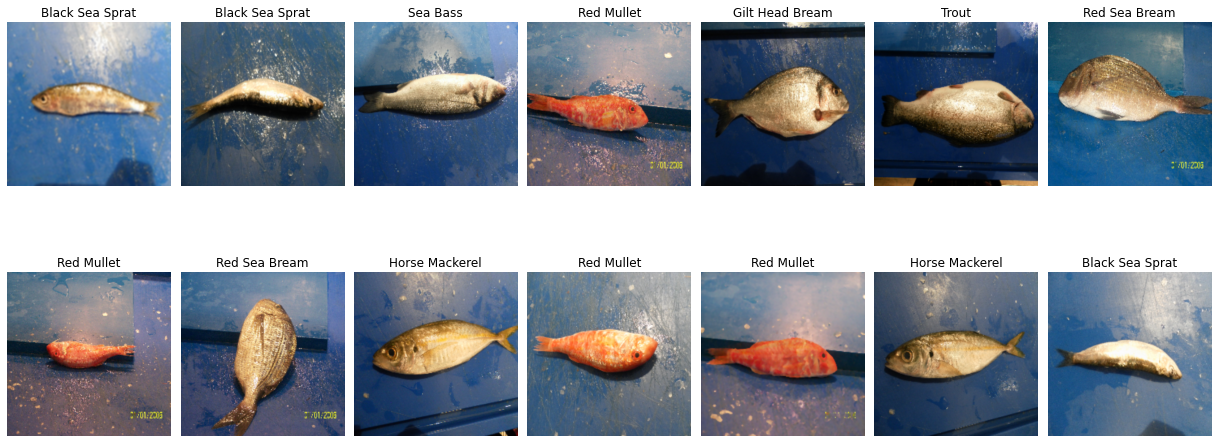

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline



def visualize_augmentations(dataset, idx=0, samples=14, cols=7, random_img = False):
    
    dataset = copy.deepcopy(dataset)

    # it is asking, if there is transform in that dataset, then take it as "t"
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]) 
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(17, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(dataset))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_cls[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset, random_img = True)

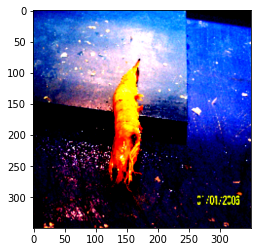

In [11]:
images, label = next(iter(dataloaders['train']))
for i, data in enumerate(images, 1):
    plt.imshow(data.permute(1,2,0).numpy())


# **Model Building**

### **With Inception Net**

In [12]:
# from torchvision.models import 
model = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [13]:
# freezing training for all layers
for params in model.parameters():
    params.requires_grad = False

In [14]:
# model

In [15]:
model.AuxLogits.fc = nn.Linear(768, 9)
model.fc = nn.Linear(2048, 9)

In [16]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

## **Hyperparameters**

In [17]:
def visualize_loss(num_epochs, Training_Loss, Validation_Loss):
    print("\nGraphs of Losses")
    epochGraph = range(1, num_epochs+1)
    figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    figure.suptitle("Losses w.r.t Epochs", weight='bold', size=30)
    ax1.set_title('Training loss')
    ax1.plot(epochGraph,Training_Loss, 'tab:orange')
    ax2.set_title('Validation loss')
    ax2.plot( epochGraph,Validation_Loss, 'tab:green')

In [18]:
from torch.optim import lr_scheduler
import time

optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)
# lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=- 1, verbose=False)
lambda2 = lambda epoch: 0.95**epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)


# **Training & Validation Phase**

In [19]:
def train_model(model, criterion, optimizer,scheduler,patience=10, num_epochs=3, checkpoint=True):
    # Early stopping
    last_loss = 100
    patience = patience
    trigger_times = 0   
    Training_Loss = []
    Validation_Loss = []
    best_acc = 0
    Low_Loss = 10

    since = time.time() 

    for epoch in range(1, num_epochs+1):
        print('\nEpoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Optimization
                # with torch.no_grad if phase=='Train':
                if phase == 'train':
                    # Loss 
                    outputs, x= model(inputs)
                    loss = criterion(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    
                else: 
                    outputs= model(inputs)
                    loss = criterion(outputs, labels)              # Loss 


                _, preds = torch.max(outputs, 1)  # 1 = Row wise max, preds = index of max predicted image, for comparing to label
                running_loss += loss.item() * inputs.size(0)  # for getting Cost 
                running_corrects += torch.sum(preds == labels.data)

            if phase=='train':
                epoch_loss = running_loss / len(train_dataset)
                Training_Loss.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(train_dataset)
                print(f'{phase} loss is: {epoch_loss:.4f}, and accuracy is : {epoch_acc:.4f}')
                
            else:
                epoch_loss = running_loss / len(test_dataset) # lenght will be same for val, train
                epoch_acc = running_corrects.double() / len(test_dataset)
                Validation_Loss.append(epoch_loss)
                print(f'{phase} loss is: {epoch_loss:.4f}, and accuracy is: {epoch_acc:.4f}\n')
                
                if epoch_acc>best_acc and checkpoint and epoch_loss<Low_Loss:
                    print(f'So far, {epoch} epoch has best model.\n ==> saving checkpoints\n')
                    checkpoint = {'State_dic':model.state_dict(), 'Optimizer': optimizer.state_dict()}
                    torch.save(checkpoint, 'checkpoint.tar')                    
                    best_acc = epoch_acc 
                    Low_Loss = epoch_loss
                
                # Custom Early Stopping
                if epoch_loss > last_loss:
                    trigger_times += 1
                    print('Trigger Times:', trigger_times)
                    
                    if trigger_times >= patience:
                        return ('Sorry for Early stopping, Model is not improving....')
                else:
                    print('Trigger Times: 0')

                last_loss = epoch_loss
    
    # Extra Stuff    
    # 1) Time Calculation
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')
    
    # 2) Plotting Graphs
    visualize_loss(num_epochs, Training_Loss, Validation_Loss)
    



Epoch 1/50
----------
train loss is: 5.0039, and accuracy is : 0.1667
validation loss is: 9.7819, and accuracy is: 0.1512

So far, 1 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 2/50
----------
train loss is: 4.4659, and accuracy is : 0.1822
validation loss is: 6.3749, and accuracy is: 0.2791

So far, 2 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 3/50
----------
train loss is: 2.4194, and accuracy is : 0.4070
validation loss is: 2.4751, and accuracy is: 0.5116

So far, 3 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 4/50
----------
train loss is: 1.8211, and accuracy is : 0.4690
validation loss is: 2.0102, and accuracy is: 0.5581

So far, 4 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 5/50
----------
train loss is: 1.0564, and accuracy is : 0.6357
validation loss is: 1.0692, and accuracy is: 0.6860

So far, 5 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 6/5

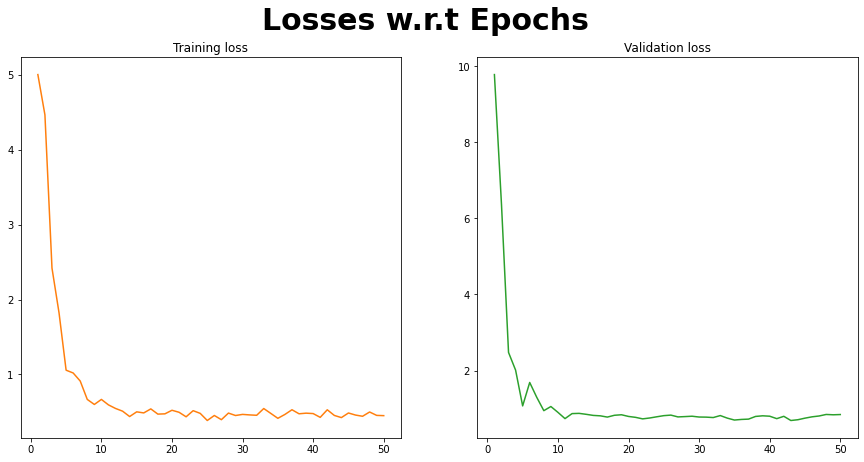

In [20]:
train_model(model, criterion, optimizer, scheduler, num_epochs=50,patience=25 ,checkpoint=True)

# **Loading the best model**

In [21]:
checkpoint = torch.load('checkpoint.tar')
model.load_state_dict(checkpoint['State_dic'])
optimizer.load_state_dict(checkpoint['Optimizer'])

# torch.save(model)

# **Testing Phase**
- with Batches

In [22]:
def check_accuracy(loader, model, train=True):
    num_correct = num_samples = 0
    model.eval()
    
    
    with torch.no_grad():
      for input, labels in loader:
        input = input.to(device=device)
        labels = labels.to(device=device)
        batch_size = input.shape[0]
    
        outputs = model(input)
        _, preds = outputs.max(1)
        num_correct += (preds == labels).sum()
        num_samples += preds.size(0)
    
    accuracy = (num_correct.item()/num_samples)*100
    
    print(f"Model Predicted {num_correct.item()} correctly out of {num_samples} from Testing dataset, Accuracy : {accuracy:.2f}")

    model.train()


    
check_accuracy (dataloaders['test'], model, train=False)


Model Predicted 71 correctly out of 86 from Testing dataset, Accuracy : 82.56


# **Testing on Single Images**

In [23]:
# model = torch.load(PATH)
import io
model.eval()

def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(200),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor = tensor.to(device)
    output = model(tensor)

    prob, classes = torch.max(output, 1)
    name=idx_to_cls[classes.item()]
    return name, prob

def read_image(image_path):
#     image_path = input("Past the Path - ")
    # Need to convert Image_path into Image for watching at the end
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    f = open(image_path, 'rb') 
    image_bytes = f.read()
    # need to give original image path, because it is transforming
    name, prob = get_prediction(image_bytes=image_bytes)
    prob = int(prob[0])

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"Name of the Fish is {name}, with {prob}% Probability ")

# read_image(image_path)

In [24]:
image_paths = ['../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00003.png',
              '../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Gilt Head Bream/13.JPG',
               '../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Horse Mackerel/00006.png',
               '../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Red Mullet/00008.png',
               '../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Red Sea Bream/100_1479.JPG',
               '../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Sea Bass/16.JPG',
               '../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Shrimp/00010.png',
               '../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Striped Red Mullet/00009.png',
               '../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Trout/00007.png',
              ] 

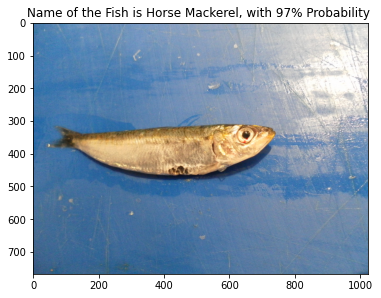

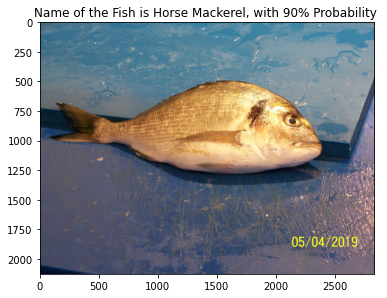

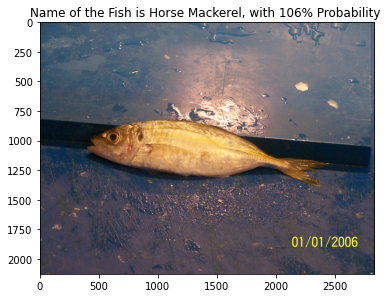

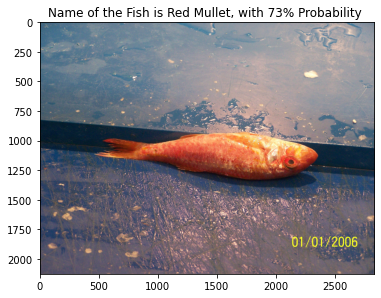

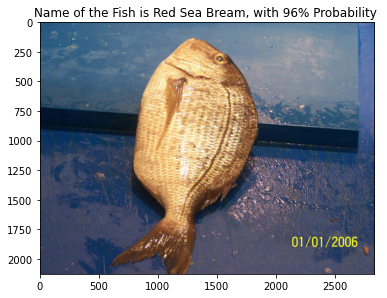

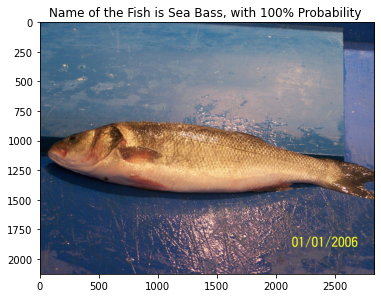

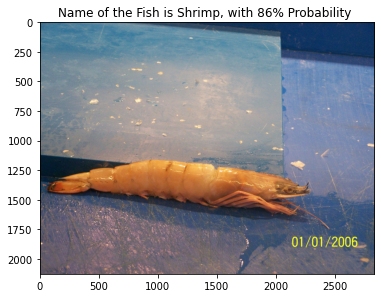

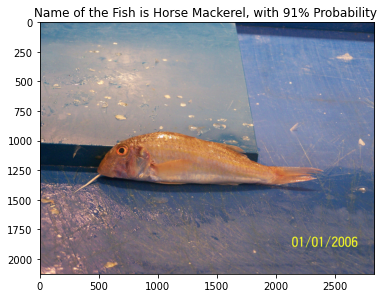

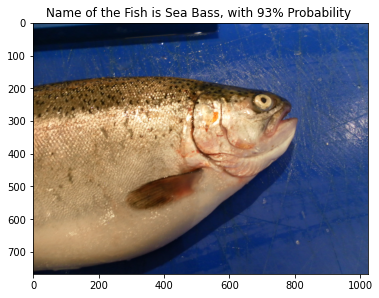

In [25]:
for i in image_paths:
    read_image(i)

# **Rough Work**

In [26]:
# from PIL import Image
# import requests
# from io import BytesIO



# def read_image():
#     inp = int(input("Enter 0 to read image form URL\n Enter 1 to read Image from current directory:\n\t\t= "))
#     if inp ==0:
#         url = input("Past Image URL= ")
#         url = r'url'
#         response = requests.get(url)
#         image = Image.open(BytesIO(response.content))
#     else:
#         path = str(input("Past the Path of Image"))
#         f = open(path, 'rb') 
#         image = f.read()
    
#     name, prob = get_prediction(image_bytes=image)
#     prob = int(prob[0])

#     plt.figure(figsize=(6,6))
#     plt.imshow(image)
#     plt.title(f"Name of the Fish is {name}, with {prob}% Probability ")
    
        

In [27]:
# read_image()

In [28]:
# from PIL import Image
# import requests
# from io import BytesIO

# url = r'https://www.shutterstock.com/image-photo/raw-seabass-one-fresh-sea-bass-1613584021'
# response = requests.get(url)
# image = Image.open(BytesIO(response.content))

In [29]:
# from PIL import Image
# import numpy

In [30]:
# # image = next(iter(dataloaders['test']))[0][1].numpy()
# from torch.autograd import Variable

# image = Image.open('../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Gilt Head Bream/10.JPG')
# image = numpy.array(image)
# print(type(image))


In [31]:
# def Prediction(image, transform):
#     model.eval()
#     image = transform(image=image)["image"]
#     image = image.to(device)
# #     image = image.permute(1,2,0).numpy()

#     image = Variable(image.view([-1, 3, 224, 224]))
#     outputs = model(image)
#     index = outputs.data.numpy().argmax()

# #     plt.imshow(img.numpy().transpose((1, 2, 0)))

# #     image = cv2.imread(image_filepath)
# #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# #     image = image_filepath.to(device)
# #     image = torch.tensor(image_filepath)
# #     image = torch.unsqueeze(torch.tensor(image), 0)



# #     image = image_filepath.to(device)
# #     plt.imshow(image)
    
# #     output= model(image)    
# #     outputs = model(input)
# #     _, preds = outputs.max(1)
# #     name = idx_to_cls[preds]
# #     return index


In [32]:
# Prediction(image, train_transforms)

In [33]:
# train_model(model, criterion, optimizer, scheduler, num_epochs=40, checkpoint=True)

In [34]:
# def objective(trial):
    
#     model.to(device)
#     # generate optimizer
#     optimizer_name = trail.suggest_categorical("optimizer", ["Adam","RMSprop", "SGD"])
#     lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
#     optimizer = getattr(optim, optimizer_name)(model.get_parameter(), lr=lr)
    
#     #  Training the models
#     for epoch in range(EPOCHS):
#         model.train()
#         for batch_idx, (data, target) in enumerate(dataloaders['train']):
#             data = data.to(device)
#             target = target.to(device)
            
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, label)
#             loss.backward()
#             optimizer.step()
            
#         # VAlidation of the model
#         model.eval()
#         correct = 0
#         with torch.no_grad():
#             for batch_idx, (data, target) in enumerate(dataloaders['validation']):
#                 data = data.to(device)
#                 target = target.to(device)
#                 output = model(data)
#                 # Get the index of the max log-probability.
#                 pred = output.argmax(dim=1, keepdim=True)
#                 correct += pred.eq(target.view_as(pred)).sum().item()

#         accuracy = correct / len(valid_dataset)

#         trail.report(accuracy, epoch)
        
#         # Handle pruning based on the intermediate value.
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#     return accuracy



# if __name__ == "__main__":
#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=10, timeout=600)

#     pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
#     complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

#     print("Study statistics: ")
#     print("  Number of finished trials: ", len(study.trials))
#     print("  Number of pruned trials: ", len(pruned_trials))
#     print("  Number of complete trials: ", len(complete_trials))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: ", trial.value)

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))